# Trabalho Prático 1
Universidade Federal de Minas Gerais, 2023.

Trabalho sobre Geometria Computacional apresentado para a disciplina Algoritmos 2.

**Nome:** Brisa do Nascimento Barbosa

**Matricula:**

**Nome:** Mateus Krause Eleoterio

**Matricula:**

**Nome:** Henrique Matos de Vasconcellos

**Matricula:**



## Introdução
Neste trabalho, nos dedicamos ao desenvolvimento de um algoritmo de aprendizado supervisionado destinado à criação de um modelo de classificação. Esse modelo tem como objetivo atribuir rótulos a amostras desconhecidas com base nas características extraídas de um conjunto de treinamento. A premissa fundamental é a de que, ao entender as características principais das amostras: de treinamento com diferentes rótulos, nosso algoritmo será capaz de generalizar e fazer previsões precisas para novos dados.

Para isso, debruçamos sobre a revisão e aplicação prática de algoritmos geométricos previamente estudados em aula. Dentre eles. Com eles, explicitamos a abordagem implementada:

Dado um conjunto de dados bidimensional com duas classes, exploramos
* Determinar a envoltória convexa das classes, e, com isso, verificar se são linearmente separáveis (se há ou não interseção entre elas)
* Definir um modelo de classificação, que traça uma reta perpedicular ao segmento mínimo entre as classes, e, com isso, determina a qual classe cada ponto pertence a partir da divisão da reta perpendicular
* Avaliação de desempenho do classificador utilizando métricas: precisão, revocação e f1-escore.



## Base


Definições e pré-processamentos necessários para os algoritmos

[ hablar mais ]

### Bibliotecas

O código utiliza as bibliotecas matplotlib, math, pandas, e numpy. O matplotlib é uma biblioteca visual que nos auxilia na visualização dos gráficos. Da biblioteca math, usamos atan2 para cálculo de ângulo polar. Pandas é utilizado para importar, manipular e analisar dados tabulares. Por fim, o scikit-learn para computação de métricas.

In [106]:
import matplotlib.pyplot as plt
from math import atan2
import pandas as pd

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

### Classes

Encapsulamos os objetos geométricos em três classes: Point, Segment e Reta.
* Point:

  A classe Point simplemente armazena as coordenadas x e y de um ponto. O atributo segment pode ser utilizado para rastrear a qual segmento o ponto pertence (se pertence à algum).
* Segment:

  Define os segmentos pelo ponto de início 'start' e o ponto final 'end'. Inclui também um atributo opcional, que é a envoltória 'hull' que o pertence (se pertence à alguma). Caso um segmento seja vertical, alteramos ligeiramente sua coordenada x a fim de evitar casos indesejados na varredura linear. Além disso, são fornecidos métodos que calculam o ponto médio do segmento, a equação da reta que passa pelo segmento e o 'find_y', que encontra um x de acordo a equação e um y passado por parâmetro.

* Reta:

  Representa uma reta pelo seu declive e interseção, isto é, de acordo a forma geral de uma equação de reta no plano, y = m*x + a\, em que m é o seu declive e b a interseção com o eixo y.


In [107]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.segment_start = None
        self.segment_end = None

    def __lt__(self, other):
        # compara para ordenar pontos com base nas coordenadas x, usando y como desempate
        if self.x < other.x:
            return True
        elif self.x == other.x:
            return self.y < other.y
        else:
            return False

class Segment:
    def __init__(self, start, end, hull = None):
        if start.x == end.x: #evitar retas verticais na varredura
            start.x += 0.0001

        if start.x > end.x:
            start, end = end, start

        # Talvez mudar aqui
        self.start = start
        self.end = end
        self.start.segment = self  # Atribui o segmento ao ponto de início
        self.end.segment = self  # Atribui o segmento ao ponto final

        self.hull = hull  # Armazena uma referência ao conjunto

    @property
    def mid_point(self):
        x_mid = (self.start.x + self.end.x) / 2
        y_mid = (self.start.y + self.end.y) / 2
        return Point(x_mid, y_mid)

    @property
    def equation(self):
        m = (self.end.y - self.start.y) / (self.end.x - self.start.x)
        b = self.start.y - m * self.start.x
        return m, b

    def find_y(self, x):
        m, b = self.equation
        y = m * x + b
        return y

class Reta:
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept

    def equation(self):
        return f'y = {self.slope}x + {self.intercept}'

### Preparação do DataSet

Para atender aos critérios apresentador, temos que tratar os datasets que utilizaremos. Por padrão, decidimos ler arquivos *csv* hospedados em algum repositório remoto e realizar o tratamento adequado dos dados.

Como nossa fonte principal de dados é o [KEEL dataset repository](https://sci2s.ugr.es/keel/category.php?cat=clas#inicio) os dados são formatados de maneira específica para essa aplicação. Felizmente, podemos obter os mesmos dados já convertidos para nosso formato já que foram disponibilizados por terceiros em um [repositório](https://github.com/Mereep/keel_csv) no Github.

Para não precisarmos utilizar os métodos do SciKit Learn para conseguir os datasets de teste inclusos, foi feito o upload de seus arquivos fonte para um repositório de datasets.

Todos os dados foram agrupados em um [repositório único](https://github.com/mateuskrause/keel-sklearn-csv) para facilitar o acesso.

Após, temos que fazer alterações nos dados para se adequarem ao nosso modelo de leitura.

In [108]:
# carrega o dataset informado, tratando as entradas e retornando processado
def load_dataset(url, default_classification, seed = 12, attribute_x='Dimension 1', attribute_y='Dimension 2'):

    data = pd.read_csv(url)
    attribute_target = data.columns[-1]

    # filtra a classificação (é ou não é o atributo)
    data = simplify_classification(data, default_classification, attribute_target)

    # filtra para manter apenas as duas primeiras classes alvo na ordem de leitura
    data = condense_dataset(data)

    # atributo alvo padrão após a condensação
    attribute_target = 'Class'

    # embaralha o conjunto de dados com seed 12 (aniversário Sasa)
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    # divide o conjunto de dados em treinamento (70%) e teste (30%)
    train_size = int(0.7 * len(data))
    x_train = data.loc[:train_size - 1, [attribute_x, attribute_y]]
    y_train = data.loc[:train_size - 1, attribute_target]
    x_test  = data.loc[train_size:, [attribute_x, attribute_y]]
    y_test  = data.loc[train_size:, attribute_target]

    # preenche o dataset com os conjuntos respectivos
    dataset = {
        "x_train": x_train,
        "y_train": y_train,
        "x_test": x_test,
        "y_test": y_test
    }

    return dataset

Para podermos separar com uma linha em um espaço bidimensional, temos que possuir apenas duas classificações possíveis. Dessa maneira, é utilizada a classificação de acordo com uma característica. Logo, renomeamos as classificações como sendo "é essa característica" ou "não é essa característica". Para um melhor controle, definimos manualmente o que queremos classificar a partir de uma variável.

Grande parte dos datasets públicos disponíveis possuem múltiplas colunas de informações (features) e, se prosseguirmos dessa maneira, teríamos um espaço n-dimensional com um hiperplano separando nossa classificação caso dados separáveis. Já que não é do intuito do trabalho, utilizamos então o algoritmo de decomposição de valor singular (SVD) para diminuir para duas colunas, isto é, transformálos em bidimensionais. Utilizamos a implementação padrão na biblioteca *sklearn*.

Após os dados serem ajustados, os embaralhamos (é comum as classificações virem juntas) e separamos uma parte para o treino do nosso modelo e outra para o teste.

Armazenamos nossas informações de uma forma padronizada, onde *x_train* carrega as features de treinamento e *y_train* as classificações de treinamento. de forma análoga para o teste, temos *x_test* e *y_test*.

In [109]:
# obtém dois conjuntos de pontos para cada tipo no target
def split_points_by_classes(x_, y_):

    # verifica se usuário inseriu o atributo de classificação corretamente
    unique_classes = set(y_)
    if len(unique_classes) != 2:
        raise ValueError("Verifique se a classificação padrão está correta. Erro: não há classif. distintas")

    # separa cada coordenada dos pontos para uma dimensão
    class1, class2 = list(unique_classes)
    points_1 = []
    points_2 = []

    for i, row in x_.iterrows():
        if y_.iloc[i] == class1:
            points_1.append(Point(row['Dimension 1'], row['Dimension 2']))
        else:
            points_2.append(Point(row['Dimension 1'], row['Dimension 2']))

    return points_1, points_2

# usa SVD para diminuir a dimensão dos dados para 2
def condense_dataset(data):

    # separa as features (X) e o alvo (y)
    target_column = data.columns[-1]
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # inicializa com duas dimensões
    svd = TruncatedSVD(n_components=2)

    # aplica a redução de dimensão aos dados
    transformed_data = svd.fit_transform(X)

    # cria o dataframe com os dados processados
    result = pd.DataFrame({'Dimension 1': transformed_data[:, 0], 'Dimension 2': transformed_data[:, 1], 'Class': y}) # nomes default, usados como chave depois

    return result

# remove especificidade da classificação, transformando apenas em 0 ou 1
def simplify_classification(dataset, true_classification, attribute_target):

    def convert_classification(classification):
        if classification == true_classification:
            return 1
        else:
            return 0

    dataset[attribute_target] = dataset[attribute_target].apply(convert_classification)

    return dataset

## Algoritmos Geométricos


Geometria *Helpeeerrrs*



In [110]:
def direction(p0, p1, p2):
    return ((p1.x - p0.x)*(p2.y - p0.y) - (p2.x - p0.x)*(p1.y - p0.y))

def distance(p1, p2):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def on_segment(p0, p1, p2):
    if min(p0.x, p1.x) <= p2.x <= max(p0.x, p1.x) and min(p0.y, p1.y) <= p2.y <= max(p0.y, p1.y):
        return True
    return False

### Árvore de Segmentos

Utilizada na função que detecta interseção entre envoltórias.

In [111]:
class Node:
    def __init__(self, segment):
        self.segment = segment
        self.left = None
        self.right = None
        self.height = 1 # Altura inicial da árvore é 1

class AVLTree:
    def getHeight(self, node):
        if not node:
            return 0
        return node.height

    def getBalance(self, node):
        if not node:
            return 0
        return self.getHeight(node.left) - self.getHeight(node.right) # Fator de equilíbrio do nó

    def rotateLeft(self, z):
        y = z.right
        T2 = y.left

        y.left = z
        z.right = T2

        z.height = 1 + max(self.getHeight(z.left), self.getHeight(z.right))
        y.height = 1 + max(self.getHeight(y.left), self.getHeight(y.right))

        return y

    def rotateRight(self, y):
        x = y.left
        T2 = x.right

        x.right = y
        y.left = T2

        y.height = 1 + max(self.getHeight(y.left), self.getHeight(y.right))
        x.height = 1 + max(self.getHeight(x.left), self.getHeight(x.right))

        return x

    def insert(self, root, segment, x):
        # Insere ordenamente de acordo com a linha de varredura em determinado x
        if not root:
            return Node(segment)

        if segment.find_y(x) < root.segment.find_y(x):
            root.left = self.insert(root.left, segment, x)
        elif segment.find_y(x) > root.segment.find_y(x):
            root.right = self.insert(root.right, segment, x)
        else:
            return root

        root.height = 1 + max(self.getHeight(root.left), self.getHeight(root.right))

        balance = self.getBalance(root)

        if balance > 1:
            if segment.find_y(x) < root.left.segment.find_y(x):
                return self.rotateRight(root)
            else:
                root.left = self.rotateLeft(root.left)
                return self.rotateRight(root)

        if balance < -1:
            if segment.find_y(x) > root.right.segment.find_y(x):
                return self.rotateLeft(root)
            else:
                root.right = self.rotateRight(root.right)
                return self.rotateLeft(root)

        return root

    def delete(self, root, segment, x):
        # Deleta também de acordo com a linha de varredura em determinado x
        if not root:
            return root

        if segment.find_y(x) < root.segment.find_y(x):
            root.left = self.delete(root.left, segment, x)
        elif segment.find_y(x) > root.segment.find_y(x):
            root.right = self.delete(root.right, segment, x)
        else:
            if (not root.left) or (not root.right):
                temp = root.left if root.right is None else root.right

                if temp is None:
                    temp = root
                    root = None
                else:
                    root = temp

                temp = None
            else:
                temp = self.getMinValueNode(root.right)
                root.segment = temp.segment
                root.right = self.delete(root.right, temp.segment, x)

        if root is None:
            return root

        root.height = 1 + max(self.getHeight(root.left), self.getHeight(root.right))

        balance = self.getBalance(root)

        if balance > 1:
            if self.getBalance(root.left) >= 0:
                return self.rotateRight(root)
            else:
                root.left = self.rotateLeft(root.left)
                return self.rotateRight(root)

        if balance < -1:
            if self.getBalance(root.right) <= 0:
                return self.rotateLeft(root)
            else:
                root.right = self.rotateRight(root.right)
                return self.rotateLeft(root)

        return root

    def getMinValueNode(self, node):
        if node is None or node.left is None:
            return node

        return self.getMinValueNode(node.left)

    def inOrderReverse(self, root):
        # Impressão opcional da ordem dos segmentos de cima para baixo na linha de varredura
        if root:
            self.inOrderReverse(root.right)
            print(root.segment.number, end=" ")
            self.inOrderReverse(root.left)

    def findPredecessor(self, root, segment, x): # ABAIXO
        if not root:
            return None

        predecessor = None
        while root:
            if segment.find_y(x) > root.segment.find_y(x):
                predecessor = root
                root = root.right
            else:
                root = root.left

        return predecessor

    def findSuccessor(self, root, segment, x): # ACIMA
        if not root:
            return None

        successor = None
        while root:
            if segment.find_y(x) < root.segment.find_y(x):
                successor = root
                root = root.left
            else:
                root = root.right

        return successor

    def swapSegments(self, root, segment1, segment2, x):
        # Basicamente, deleta e insere de novo
        root = self.delete(root, segment1, x)
        root = self.delete(root, segment2, x)

        point1, point2 = segment1.start, segment2.start
        point1.segment, point2.segment = point2, point1
        segment1.start, segment2.start = point2, point1
        point1, point2 = segment1.end, segment2.end
        point1.segment, point2.segment = point2, point1
        segment1.end, segment2.end = point2, point1

        root = self.insert(root, segment1, x)
        root = self.insert(root, segment2, x)

        return root

    def clearTree(self, root):
        """
        Limpa a árvore, eliminando todos os nós.
        """
        if root:
            root.left = self.clearTree(root.left)
            root.right = self.clearTree(root.right)
            root = None
        return None


### Interseções


Aqui, implementamos dois algoritmos de intereseção. Um entre dois segmentos e outro entre segmentos das duas envoltórias. O primeiro é utilizado no segundo.
O algoritmo da interseção de quaisquer 2 segmentos da seguinte forma:

In [112]:
def segments_intersect(seg1, seg2):
    p0, p1 = seg1.start, seg1.end
    p2, p3 = seg2.start, seg2.end

    d1 = direction(p2, p3, p0)
    d2 = direction(p2, p3, p1)
    d3 = direction(p0, p1, p2)
    d4 = direction(p0, p1, p3)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True
    elif d1 == 0 and on_segment(p2, p3, p0):
        return False
    elif d2 == 0 and on_segment(p2, p3, p1):
        return False
    elif d3 == 0 and on_segment(p0, p1, p2):
        return False
    elif d4 == 0 and on_segment(p0, p1, p3):
        return False
    else:
        return False

Com isso, a função segments_intersect_hull adapta o pseudocódigo descrito em Cormen (coloco como referência bibliográfica?), o qual funciona para um conjunto único de segmentos. No nosso caso, generalizamos para dois conjuntos quaisquer de segmentos. Ainda, foi preferível implementar uma AVL ao invés de utilizar uma árvore vermelho-preta, como sugerido no Cormen, garantem um balanceamento estrito, o que resulta em profundidades de árvore mais uniformes e pela facilidade de implementação neste caso.

O algoritmo que checa interseção entre dois conjuntos de segmentos distintos funciona da seguinte forma:
 abordagem começa por unir todos os segmentos em um único conjunto S, onde os pontos iniciais e finais dos segmentos são armazenados em uma lista ordenada B. Em seguida, a função utiliza uma Árvore AVL para manter um registro dos segmentos enquanto a varredura progride. A varredura percorre os pontos em B e, para cada ponto, verifica se é o ponto de início ou fim de um segmento. Se for um ponto de início, o segmento é inserido na árvore, e as interseções com segmentos adjacentes (abaixo e acima) são verificadas. Se houver interseções, a função verifica se os segmentos pertencem ao mesmo conjunto, se sim e realiza um swap para resolver interseções internas sem alterar a ordem dos segmentos de cima para baixo. Se os segmentos não pertencerem ao mesmo conjunto, encontramos uma interseção válida
 Se um ponto de fim é encontrado, o segmento correspondente é removido da árvore. Testamos então se o segmento abaixo e acima intersectam e verificamos se a interseção é válida ou se realizam um swap assim como definido anteriormente. A função prossegue dessa maneira até que todos os pontos tenham sido processados. Se nenhuma interseção entre os conjuntos de segmentos for encontrada durante a varredura, então não há interseções entre os segmentos.
 Essa abordagem eficiente permite determinar interseções entre segmentos de maneira organizada e escalável. Assim, quando não ocorre interseção,

In [113]:
def segments_intersect_hull(hull_1, hull_2):
    B = sorted(hull_1 + hull_2, key=lambda p: (p.x, p.y))

    T = AVLTree()
    root = None

    for point in B:
        x = point.x

        if point.segment_start is not None:
            s = point.segment_start
            root = T.insert(root, s, x)

            below_seg = T.findPredecessor(root, s, x)
            above_seg = T.findSuccessor(root, s, x)

            if(above_seg is not None):
                if (s.hull != above_seg.segment.hull):
                    if segments_intersect(s, above_seg.segment):
                        return True
            if(below_seg is not None):
                if (s.hull != below_seg.segment.hull):
                    if segments_intersect(s, below_seg.segment):
                        return True
            if(above_seg is not None and below_seg is not None):
                if (below_seg.segment.hull != above_seg.segment.hull):
                    if segments_intersect(above_seg.segment, below_seg.segment):
                        return True

        if point.segment_end is not None:
            s = point.segment_end

            below_seg = T.findPredecessor(root, s, x)
            above_seg = T.findSuccessor(root, s, x)

            if(above_seg is not None):
                if (s.hull != above_seg.segment.hull):
                    if segments_intersect(s, above_seg.segment):
                        return True
            if(below_seg is not None):
                if (s.hull != below_seg.segment.hull):
                    if segments_intersect(s, below_seg.segment):
                        return True
            if(above_seg is not None and below_seg is not None):
                if (below_seg.segment.hull != above_seg.segment.hull):
                    if segments_intersect(above_seg.segment, below_seg.segment):
                        return True

            root = T.delete(root, s, x)

    T.clearTree(root)
    return False

Além disso, em muitos casos, temos uma envoltória totalmente dentro de outra.

In [114]:
def is_point_inside_hull(point, hull):
    n = len(hull)
    if n < 3:
        return False

    def is_inside_recursive(hull, left, right):
        if right - left == 1:
            p1 = hull[left]
            p2 = hull[right]

            # Use a regra da mão direita para verificar a orientação
            cross_product = (p2.x - p1.x) * (point.y - p1.y) - (point.x - p1.x) * (p2.y - p1.y)
            return cross_product >= 0

        mid = (left + right) // 2

        # Recursivamente verifica nos dois lados do polígono
        if is_inside_recursive(hull, left, mid) and is_inside_recursive(hull, mid, right):
            return True

        return False

    return is_inside_recursive(hull, 0, n - 1)

def at_least_one_point_inside(hull_1, hull_2):
  for point in hull_1:
      if is_point_inside_hull(point, hull_2):
          return True
  return False

### Envoltória Convexa

Dentre os algortimos de envoltória convexa vistos no curso, a ver, Marcha de Jarvis e Varredura de Graham, o segundo é mais interessante e mais eficiente, tendo como complexidade O(n log n), contra O(n*h) da Marcha de Jarvis.

Sendo assim, a Varredura de Graham funciona da seguinte forma:

Como esse algoritmo retorna apenas os pontos que fazem parte de uma envoltória, acrescentamos a hull_segments, que retorna os segmentos da envoltória e associa cada segmento a seu um conjunto de segmentos.

In [115]:
# Calcula a envoltória convexa com Graham-Scan
def graham(points):
    if len(points) < 3:
        return points

    # Pivo mais abaixo e à esquerda
    pivot = min(points, key=lambda p: (p.y, p.x))

    # Ordenação de acordo com ângulo polar
    sorted_points = sorted(points, key=lambda p: (atan2(p.y - pivot.y, p.x - pivot.x), p))

    hull = [sorted_points[0], sorted_points[1], sorted_points[2]]

    for i in range(3, len(sorted_points)):
        while len(hull) > 1 and direction(hull[-2], hull[-1], sorted_points[i]) <= 0:
            hull.pop()
        hull.append(sorted_points[i])

    return hull

# Retorna segmentos que fazem parte da envoltória convexa
def hull_segments(convex_hull, hull_flag):
    segments = []
    for i in range(len(convex_hull)):
        end_point = convex_hull[i]
        start_point = convex_hull[(i + 1) % len(convex_hull)]
        segment = Segment(start_point, end_point, hull_flag)
        segments.append(segment)

        # Set the segment_start and segment_end attributes for the points
        end_point.segment_end = segment
        start_point.segment_start = segment
    return segments

## Modelo de Classificação

aaa

### Reta perpendicular

[ isso aqui é usado? aa ]

In [116]:
def perpendicular_equation(point, segment):
    start = segment.start
    end = segment.end

    # declive do segmento
    if start.x != end.x:
        slope = (end.y - start.y) / (end.x - start.x)
    else:
        slope = float('inf') # reta vertival

    # declive da reta perpendicular
    if slope == 0:
        perpendicular_slope = float('inf')  # Reta horizontal
    else:
        perpendicular_slope = -1 / slope

    # termo independente da equação da reta perpendicular
    intercept = point.y - perpendicular_slope * point.x

    return Reta(perpendicular_slope, intercept)

### Modelo de Reta


Sacrificamos a eficiência a fim de uma heurística mais exata. Assim, calculamos exatamente o segmento mínimo entre as envoltórias adaptando o algoritmo ingênuo. Mas ao invés de testar ponto a ponto, testa ponto a cada segmento. Assim, para a primeira envoltória, testa qual ponto dela é mais próximo de um segmento da segunda envoltória, e vice versa, armazena esse ponto e sua distância mínima para comparação entre os dois encontrados, quando encontrados.

Para cada correspondência, testa-se point_to_segment_distance, que compara a interseção da reta perpendicular ao ponto em relação ao segmento, isto é, sua projeção ortogonal, com a distância até o ponto inicial e a distância até o ponto final.

A interseção da reta interseção da reta perpendicular ao ponto em relação ao segmento é calculada com calculate_intersection, que faz operações simples em O(1) que é basicamente colocar uma equação na outra. Alguns casos especiais é quando o segmento de reta é vertical, consideramos o ponto de início, quando são paralelas, não há interseção, quando algum slope é infinito (neste caso, é indefido, pois isso isso e isso) a interseção é o b do obejtivo vertical. Caso contrário, faz dieirinho assim assim.
Daí, no final vê se ele está no segmento bonitinho mesmo, se e retorna as coordenadas x e y como um Ponto.

In [117]:
# Calcula o ponto de interseção entre um segmento e uma reta
def calculate_intersection(segment, reta):
    x1, y1 = segment.start.x, segment.start.y
    x2, y2 = segment.end.x, segment.end.y
    m_reta, b_reta = reta.slope, reta.intercept

    if x1 == x2: # Se o segmento de reta é vertical
        x_intersection = x1
        y_intersection = m_reta * x_intersection + b_reta
    else:
        m_segment, b_segment = segment.equation

        if m_reta == m_segment: # Se segmento e reta são paralelas
            return None
        else:
            if m_reta == float('inf'): # Reta vertical
                x_intersection = b_reta
            elif m_segment == float('inf'): # Segmento vertical
                x_intersection = b_segment
            else:
                x_intersection = (b_segment - b_reta) / (m_reta - m_segment)
            y_intersection = m_reta * x_intersection + b_reta # y = m*x + b

    # Verifica se o ponto de interseção está no segmento de reta
    if (x1 <= x_intersection <= x2 or x2 <= x_intersection <= x1) and (
            y1 <= y_intersection <= y2 or y2 <= y_intersection <= y1):
        return Point(x_intersection, y_intersection)
    else:
        return None

# Calcula a menor distância entre um um ponto e um segmento
def point_to_segment_distance(point, segment):
    # Aqui, a interseção é a projeção ortogonal do ponto no segmento
    perp_eq = perpendicular_equation(point, segment)
    intersection = calculate_intersection(segment, perp_eq)

    dist = float('inf')
    closest_point = None

    dist_to_start = distance(point, segment.start)
    dist_to_end = distance(point, segment.end)

    if intersection: # Quando a interseção não é nula, é o ponto mais próximo
        dist_to_projection = distance(point, intersection)
        if dist_to_projection < dist:
            dist = dist_to_projection
            closest_point = intersection

    if dist_to_start < dist:
        dist = dist_to_start
        closest_point = segment.start

    if dist_to_end < dist:
        dist = dist_to_end
        closest_point = segment.end

    # Retorna a melhor opção de ponto entre os três pontos
    return dist, closest_point

def min_segment_between(hull_p1, hull_p2, hull_seg1, hull_seg2):
    min_distance = float('inf')
    closest_seg = None

    # Para cada ponto da envoltória, confere qual é o segmento mais próximo da outra envoltória
    for point_a in hull_p1:
        for seg_b in hull_seg2:
            dist, closest_point = point_to_segment_distance(point_a, seg_b)
            if dist < min_distance: # se melhorar, substitui
                min_distance = dist
                closest_seg = Segment(point_a, closest_point)

    for point_b in hull_p2:
        for seg_a in hull_seg1:
            dist, closest_point = point_to_segment_distance(point_b, seg_a)
            if dist < min_distance: # se melhorar, substitui
                min_distance = dist
                closest_seg = Segment(point_b, closest_point)

    return closest_seg

### Classificador

Após treinarmos nosso modelo com os dados de teste, precisamos de uma função que computa os dados de treino e obtém classificações de acordo com a separação obtida, e é exatamente o que o código a seguir faz.

Como temos uma equação de reta que delimita o domínio das nossas duas classificações, apenas precisamos saber qual a orientação de um ponto dada equação da reta (acima ou abaixo, esquerda ou direita).

Os resultados são armazenados em uma lista chamada *y_pred*, para podermos as comparar depois com os resultados verdadeiros.

In [118]:
# verificar se ponto está acima ou abaixo
# https://math.stackexchange.com/questions/1683384
def vertical_orientation(slope, intercept, point):
    value = (slope * point.x) + intercept

    if (point.y > value):
      orientation = 1
    elif (point.y < value):
      orientation = -1
    else:
      orientation = 0

    return orientation

# de acordo com uma reta e o que significa estar acima ou abaixo, roda os testes
def classifier(x_test, slope, intercept):

  y_pred = []

  # defines the expected result orientation (tenho que olhar aqui, nem sempre funcionando!)
  if(slope >= 45):
    label_above = 1
    label_below = 0
  else:
    label_above = 1
    label_below = 0

  # assign specific label
  for i, row in x_test.iterrows():

    p = Point(row.iloc[0], row.iloc[1])
    orientation = vertical_orientation(slope, intercept, p)

    if (orientation == 1):
      y_pred.append([i, label_above])
    else:
      y_pred.append([i, label_below])

  # convert to pandas data type and preserve index
  y_pred = pd.DataFrame(y_pred, columns=['Index', 'Class'])
  y_pred.set_index('Index', inplace=True)

  return y_pred


### Métricas

Para medirmos a eficiência do nosso modelo, comparamos os resultados obtidos pelo classificador dado o conjunto de teste com os verdadeiros resultados. Utilizando ferramentas do *Scikit Learn* podemos calcular a precisão (quantidade de exemplos positivos que são realmente positivos), revocação (número de exemplos positivos identificados corretamente, independente dos falsos positivos) e f1-escore (métrica que combina precisão e revocação).

In [119]:
# retorna diversas métricas de acordo com a classificação
def metrics(y_pred, y_test):

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  return precision, recall, f1


## Driver function, plot

Nosso método final *run_classification* lida com interligar todos os processos para podermos facilmente utilizar depois.

A visualização é tão importante quanto os próprios resultados, pois conseguimos de maneira fácil confirmar ou negar resultados. Dessa forma, construimos uma função inteligente que plota o gráfico dos nossos dados adequadamente.

### Plotar Gráfico

In [120]:
def plot(convex_hull1, points_with_target1, convex_hull2, points_with_target2, min_segment = None, perpendicular = None):
    # obtém pontos das envoltórias
    ch1_x, ch1_y = zip(*[(p.x, p.y) for p in convex_hull1])
    ch2_x, ch2_y = zip(*[(p.x, p.y) for p in convex_hull2])

    # obtém todos os pontos
    x1, y1 = zip(*[(p.x, p.y) for p in points_with_target1])
    x2, y2 = zip(*[(p.x, p.y) for p in points_with_target2])

    # plota pontos com primeira classificação
    plt.scatter(x1, y1, label="Conjunto 1", marker='o', color='blue', s=3.5)
    plt.plot(ch1_x + (ch1_x[0],), ch1_y + (ch1_y[0],), label='Envoltória 1', color='blue')

    # plota pontos com segunda classificação
    plt.scatter(x2, y2, label="Conjunto 2", marker='o', color='green', s=3.5)
    plt.plot(ch2_x + (ch2_x[0],), ch2_y + (ch2_y[0],), label='Envoltória 2', color='green')

    # se é linearmente separável, adiciona elementos respectivos
    if min_segment is not None and perpendicular is not None:

        # segmento entre as duas envoltórias
        p1, p2 = min_segment.start, min_segment.end
        plt.plot([p1.x, p2.x], [p1.y, p2.y], label='Seg. Mínimo', color='black')

        # ponto médio do segmento mínimo
        mid_point = min_segment.mid_point
        plt.scatter(mid_point.x, mid_point.y, color='purple', marker='x', label='Ponto Médio')

        # define limites do gráfico e informações da reta
        m, b = perpendicular.slope, perpendicular.intercept
        x_min, x_max = plt.xlim()

        # calcula a reta perpendicular dentro dos limites do gráfico
        x_interval = [x_min, x_max]
        y_values = [m * x + b for x in x_interval]
        plt.plot(x_interval, y_values, linestyle='--', color='orange', label='Reta Perp.')

    # limita tamanho do eixo y de acordo com os dados
    all_y_values = y1 + y2
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    plt.ylim(y_min - 1, y_max + 1)

    # definições do gráfico
    plt.legend()
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.grid(True)
    plt.show()


### Driver 🚗

In [121]:

# dado o dataset tratado, verifica se é separável e cria o modelo
def run_classifier(dataset):

  # obtém pontos e as envoltórias
  points_1, points_2 = split_points_by_classes(dataset["x_train"], dataset["y_train"])
  hull_1, hull_2     = graham(points_1), graham(points_2)

  # calcula os segmentos da envoltória convexa para ambas envoltórias
  hull_seg1, hull_seg2 = hull_segments(hull_1, "1"), hull_segments(hull_2, "2")

  # verifica intersecção (separabilidade)
  if segments_intersect_hull(hull_1, hull_2) or at_least_one_point_inside(hull_2, hull_1) or at_least_one_point_inside(hull_1, hull_2):

    print("Não é linearmente separável")
    # plota o gráfico
    plot(hull_1, points_1, hull_2, points_2)
  else:

    print("Envoltórias não interceptam: é linearmente separável")

    # obtém o menor segmento que liga as envoltórias e o ponto médio
    min_segment = min_segment_between(hull_1, hull_2, hull_seg1, hull_seg2) # pontos e segmentos da envoltória
    mid_point   = min_segment.mid_point

    # obtém reta perpendicular ao segmento mínimo
    perpendicular_line = perpendicular_equation(mid_point, min_segment)
    equation = perpendicular_line.equation()
    print(f"Equação da reta perpendicular: {equation}")

    # classifica os dados de teste de acordo com o treinamento
    y_pred = classifier(dataset["x_test"], perpendicular_line.slope, perpendicular_line.intercept)
    y_test = dataset["y_test"]

    # calcula métricas e apresenta resultados
    precision, recall, f1 = metrics(y_pred, y_test)

    print("Precisão:", precision)
    print("Revocação:", recall)
    print("F1-score:", f1)

    # plota o gráfico
    plot(hull_1, points_1, hull_2, points_2, min_segment, perpendicular_line)

## Testes do Modelo

Para testar nosso classificador, utilizamos dados reais de datasets públicos, tanto do [KEEL](https://sci2s.ugr.es/keel/category.php?cat=clas#inicio) quando do [Scikit Learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

Durante os testes, escolhemos classificações que representam melhor a intenção esperada (ser linearmente separável, por exemplo), dando uma breve descrição do que os dados se tratam.

Como passamos pelo processo de reduzir as dimensões, os eixos não representam uma única característica, mas sim um conjunto delas, como descrito anteriormente. Logo, não há uma visualização direta, sendo mais importante a ideia de que podemos separar ou não um conjunto de dados dada uma classificação.

### Iris

Este dataset é um dos mais famosos da literatura de reconhecimento de padrões, tendo 3 classificações possíveis com 50 instâncias cada. É conhecido que uma das classes é linearmente separável das outras duas, podendo ser comprovado com nosso modelo a seguir, o que confirma que ele está com um resultado esperado.

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = 47.459032391258134x + 54.14048400966705
Precisão: 1.0
Revocação: 1.0
F1-score: 1.0


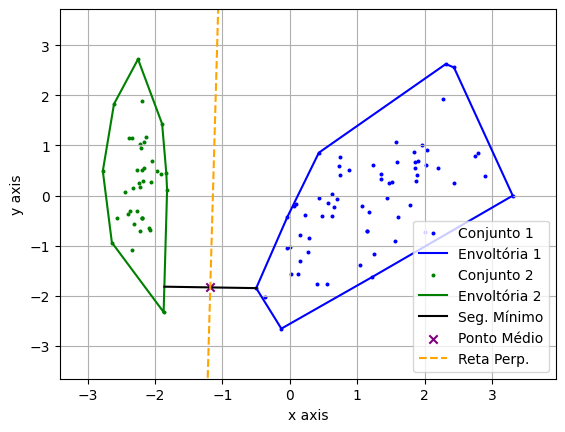

In [122]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/iris.prepared.csv"
default_classification = "Iris-setosa" # se é iris-setosa ou não... isso que iremos classificar!

iris = load_dataset(dataset_url, default_classification)

run_classifier(iris)

### Breast Cancer

Diagnóstico de cancer de mama com diversos atribudos medidos por exames médicos. Neste exemplo, vemos que dados classificados como "maligno" (em verde) mesmo tendo características menos padronizadas, ainda estão em intersecção com a classificação não maligna, em que podemos perceber que não deve ser separável com nossa abordagem.

Não é linearmente separável


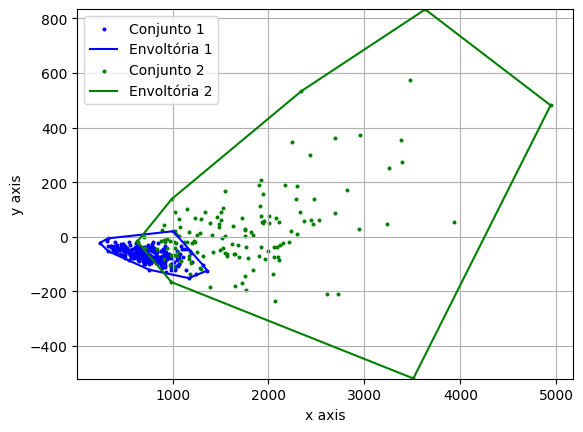

In [123]:
dataset_url = "https://raw.githubusercontent.com/mateuskrause/keel-sklearn-csv/master/sklearn_classification/breast_cancer.csv"
default_classification = 0

breast_cancer = load_dataset(dataset_url, default_classification)

run_classifier(breast_cancer)

### Segment

Este é um conjunto de dados de segmentação de imagem, onde cada classificação é uma imagem e as features representam certas características. Vemos que uma dela pode ser claramente diferenciada, sendo linearmente separável.

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = 7.891953481513433x + -32.79220897910032
Precisão: 0.0
Revocação: 0.0
F1-score: 0.0


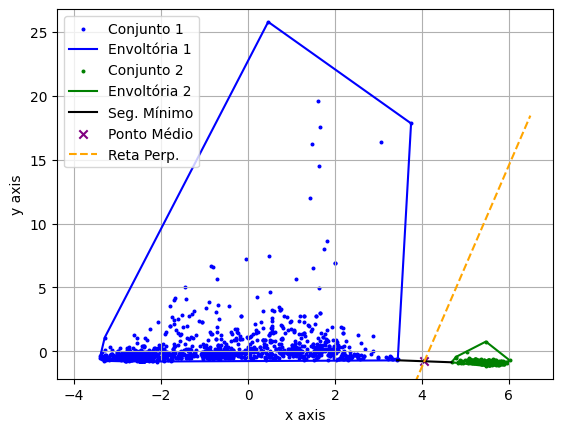

In [124]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/segment.prepared.csv"
default_classification = 2

segment = load_dataset(dataset_url, default_classification)

run_classifier(segment)

### Adult

Conjunto extraído em 1994 dos dados do censo dos Estados Unidos. Contém atributos descrevendo algumas informações sociais (idade, raça, gênero, estado civil, etc) sobre os cidadãos cadastrados. A classificação é se certo cidadão ultrapassa a renda de 50 mil dólares por ano.

Não é linearmente separável


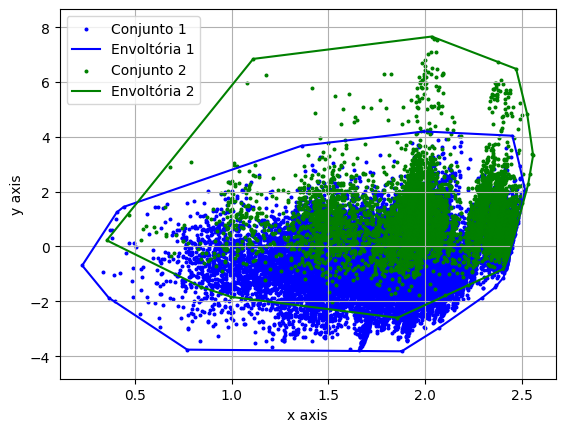

In [125]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/adult.prepared.csv"
default_classification = ">50K"

adult = load_dataset(dataset_url, default_classification)

run_classifier(adult)

### Dermatology

Exames e características de pessoas para diagnóstico de doenças eritematoescamosas.

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = -1.0678982616681003x + 1.3033453303258815
Precisão: 1.0
Revocação: 1.0
F1-score: 1.0


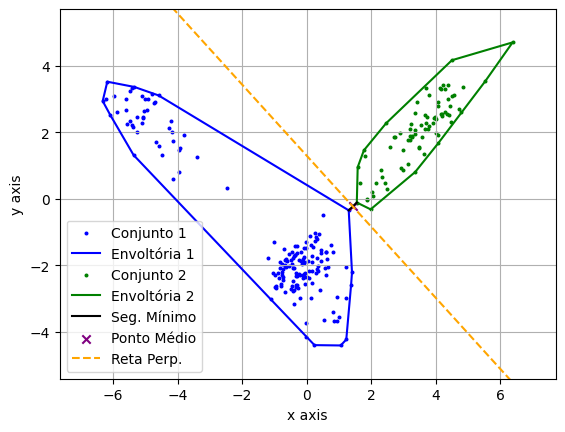

In [126]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/dermatology.prepared.csv"
default_classification = 1

galo = load_dataset(dataset_url, default_classification)

run_classifier(galo)

### Galo
Partidas do Atletico pelo Brasileirão de 2019 a 2022, fonte: https://fbref.com . Há 3 classes, vitória, derrota e empate e 2 variáveis, *expected goals* do atletico e do adversário, que é uma estatística que mede quantos gols a equipe deveria ter marcado conforme as oportunidades criadas.

O objetivo é analisar se apenas com essa estatística poderíamos prever resultados, mas vemos que o conjunto não é separável.

(Excepcionalmente este dataset está hospedado fora do repositório padrão, porém o pré-processamento seguiu os mesmos padrões)

Não é linearmente separável


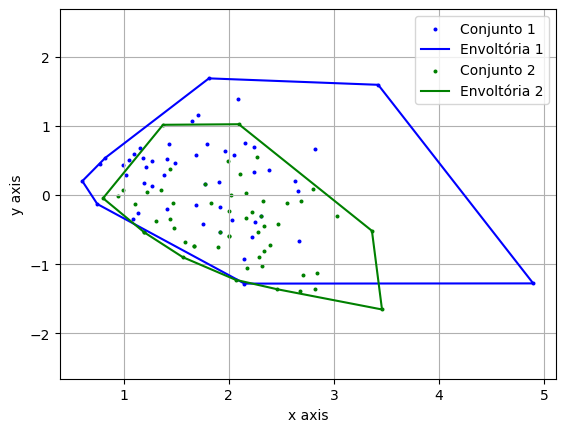

In [127]:
dataset_url = "https://drive.google.com/uc?id=1Meh9LcRo_melHMboKZ4Z_xQNgK2n1YQo"
default_classification = 1

galo = load_dataset(dataset_url, default_classification)

run_classifier(galo)

### New Thyroid

Este dataset é sobre doença da tireóide. Classificamos se um paciente possuiu hipotireoidismo ou não.

Excepcionalmente neste caso, utilizamos uma *seed* específica para o embaralhamento do dataset, isso porque os dados podem ocorrer de não ser separáveis por poucas entradas, logo podemos ter certeza que alguns daos testes trarão classificações erradas e as métricas refletem isso.

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = -12.849244654437834x + 13.375080170272904
Precisão: 1.0
Revocação: 0.5454545454545454
F1-score: 0.7058823529411764


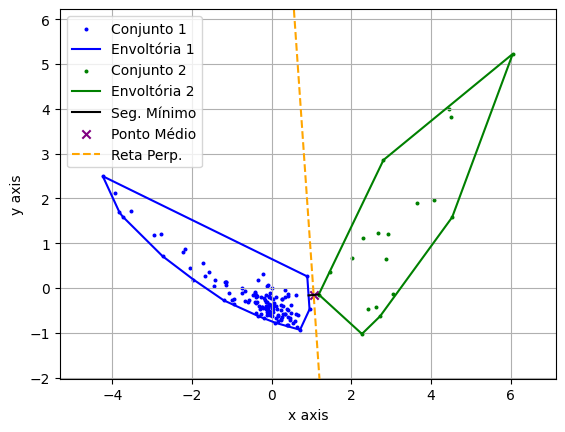

In [128]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/newthyroid.prepared.csv"
default_classification = 3

# outra seed: 462100269
dataset = load_dataset(dataset_url, default_classification, 1306254495)

run_classifier(dataset)

### Twonorm

Representa uma distribuição normal multivariada, e existe apenas duas classificações possíveis.

Não é linearmente separável


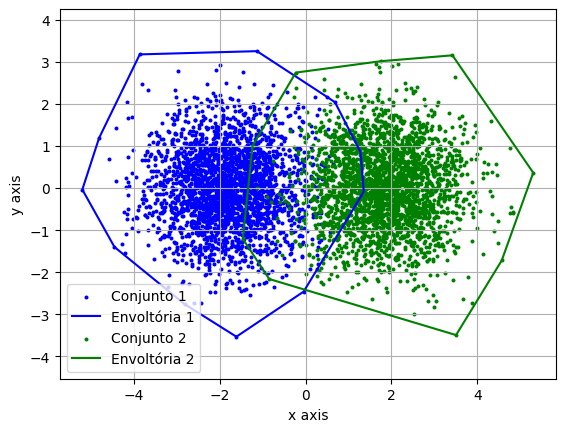

In [129]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/twonorm.prepared.csv"
default_classification = 0

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

### Zoo

Conjunto simples de características de diversos animais. Vemos que as especificidades do grupo que o urso pertence, por exemplo, é bem diferente de grupos com os seguintes representantes: galinha, tartaruga, cavalo-marinho, sapo e escorpião.

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = -0.2510711028637753x + 0.791821275658592
Precisão: 1.0
Revocação: 1.0
F1-score: 1.0


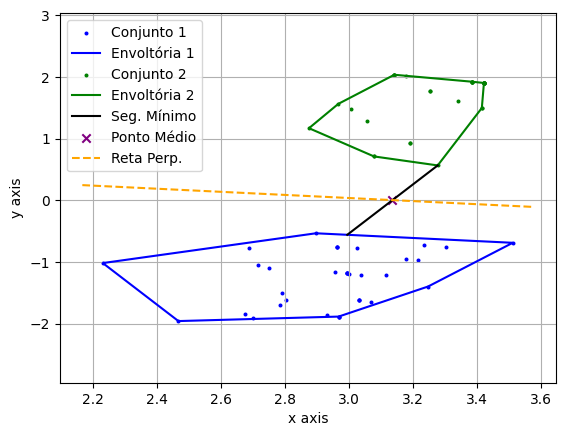

In [130]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/zoo.prepared.csv"
default_classification = 1

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

### Kr-vs-K

Um conjunto de dados de final de jogo de xadrez representa as posições no tabuleiro do rei branco, da torre branca e do rei preto. O objetivo é determinar o número ideal de turnos necessários para que as brancas ganhem o jogo, que pode se empate se demorar mais de dezesseis turnos.

Tentamos separar nesse exemplo se vai a empate ou não. É um claro exemplo de não separabilidade.

Não é linearmente separável


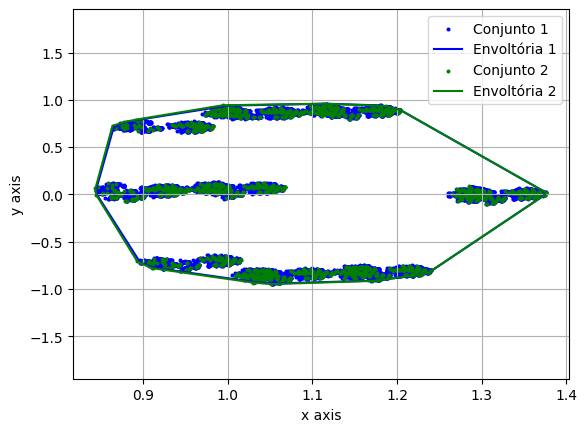

In [131]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/kr-vs-k.prepared.csv"
default_classification = "draw"

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

### Lymphography

Dados sobre presença de linfoma. Classificações sobre presença de linfoma e seu estado atual. No exemplo, tentamos classificar os ditos como fibrose.

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = -13.473859035522196x + 28.191543837360218
Precisão: 0.0
Revocação: 0.0
F1-score: 0.0


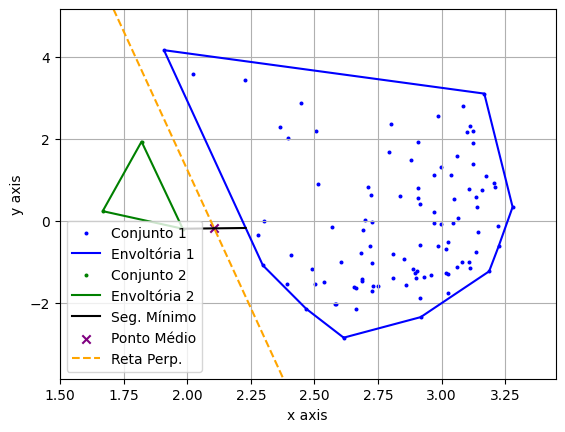

In [132]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/lymphography.prepared.csv"
default_classification = "fibrosis"

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

### Digits

Dataset contém imagens de dígitos escritos à mão. Suas características são valores de intensidade em 8x8 pixels. Tentamos aplicar nosso modelo à classificação do número 0, mas podemos esperar que não é separável.

Escolher esse ao invés de car se possível

### Extras

Datasets extras fictícios, criados para serem linearmente separáveis a fim de demonstração dos algoritmos apresentados.

#### Synthetic-1

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = 3.498633681385774x + 11.104519176315627
Precisão: 0.0
Revocação: 0.0
F1-score: 0.0


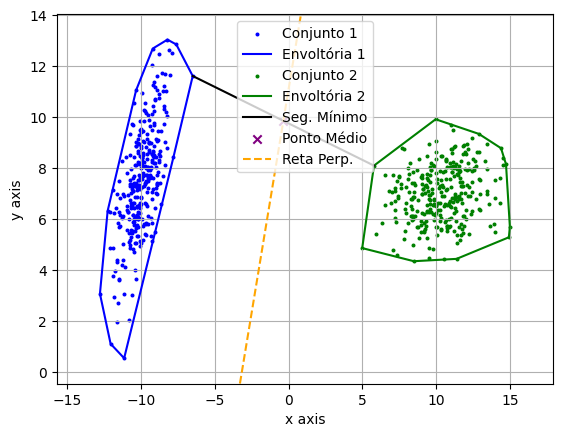

In [135]:
dataset_url = "https://drive.google.com/uc?id=1osbWeoxSb9hEbHBdX-1m4mx4VRnx4J9e"
default_classification = 1

galo = load_dataset(dataset_url, default_classification)

run_classifier(galo)

#### Synthetic-2

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = 0.18407871327701028x + -0.8213305475156073
Precisão: 0.058823529411764705
Revocação: 0.07142857142857142
F1-score: 0.06451612903225808


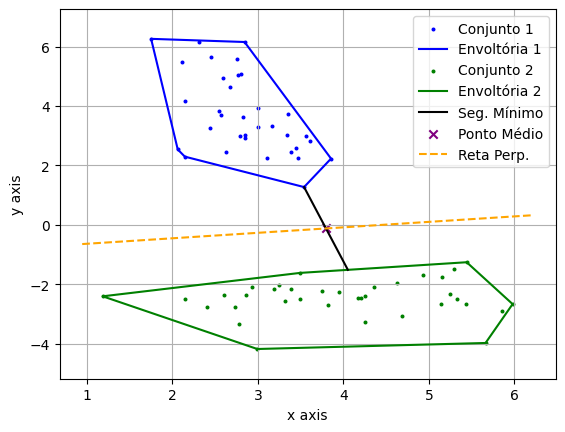

In [136]:
dataset_url = "https://drive.google.com/uc?id=1GxU2jNC9Ofw4gkHaPRfBKHrH9iq7vnuq"
default_classification = 1

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

#### Synthetic-3

Envoltórias não interceptam: é linearmente separável
Equação da reta perpendicular: y = 1.3118170581452537x + -4.82490308224202
Precisão: 0.022727272727272728
Revocação: 0.021739130434782608
F1-score: 0.02222222222222222


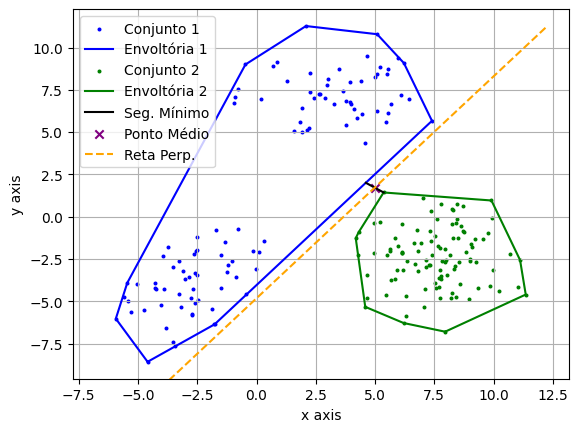

In [137]:
dataset_url = "https://drive.google.com/uc?id=1LMDoA-e7BwOyXySA1oIe5eo-zXeN_Hdq"
default_classification = 1

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

### Car

Dados sobre avaliação de automóveis, com atributos sendo características do carro e da venda. Buscamos tentar separar veículos classificados como "inaceitáveis", que estão em condições inadequadas. Vemos que neste dataset específico não conseguimos prever classificações, talvez devido a falta de informações e quantidade de dados.

Não é linearmente separável


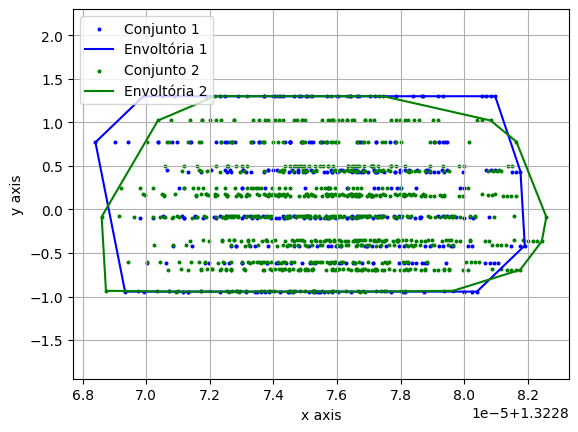

In [133]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/car.prepared.csv"
default_classification = "unacc"

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

Não é linearmente separável


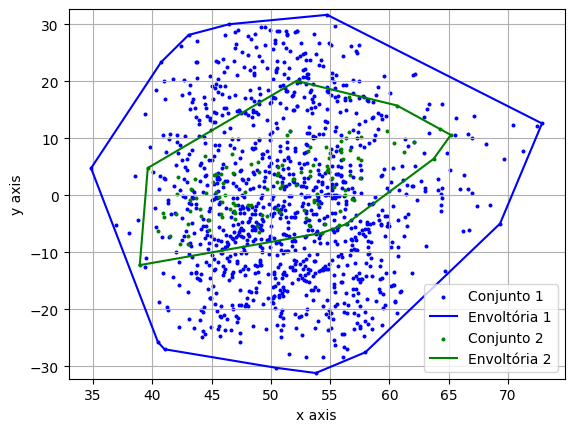

In [134]:
dataset_url = "https://raw.githubusercontent.com/mateuskrause/keel-sklearn-csv/master/sklearn_classification/digits.csv"
default_classification = 0

digits = load_dataset(dataset_url, default_classification)

run_classifier(digits)

### Wine

Não é linearmente separável


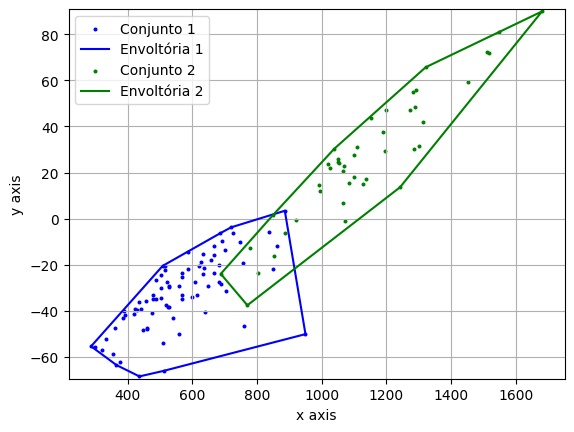

In [138]:
dataset_url = "https://raw.githubusercontent.com/mateuskrause/keel-sklearn-csv/master/sklearn_classification/wine.csv"
default_classification = 0

wine = load_dataset(dataset_url, default_classification)

run_classifier(wine)

### Apendicitis

Não é linearmente separável


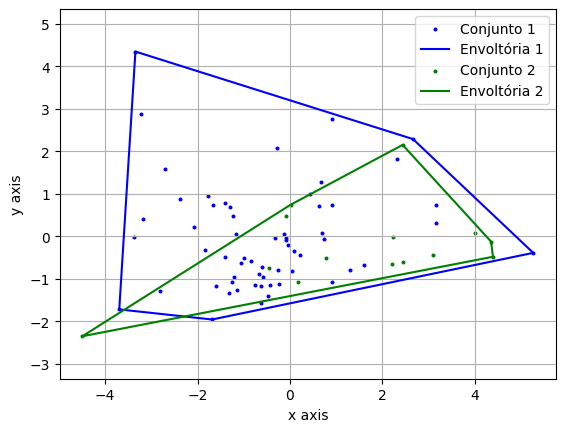

In [139]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/appendicitis.prepared.csv"
default_classification = 1

appendicitis = load_dataset(dataset_url, default_classification)

run_classifier(appendicitis)

### Australian

Não é linearmente separável


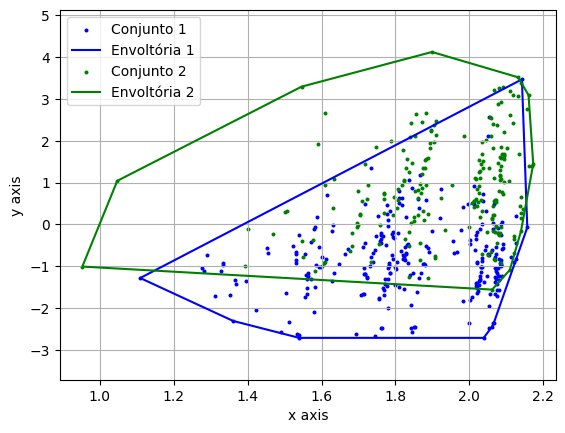

In [140]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/australian.prepared.csv"
default_classification = 1

australian = load_dataset(dataset_url, default_classification)

run_classifier(australian)

### Bands

Não é linearmente separável


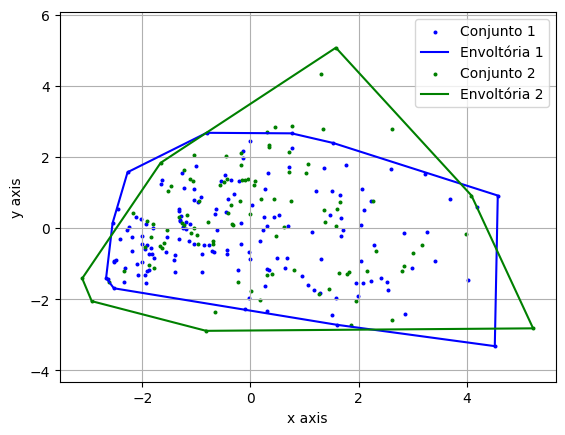

In [141]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/bands.prepared.csv"
default_classification = "band"

bands = load_dataset(dataset_url, default_classification)

run_classifier(bands)

### Nursery



Não é linearmente separável


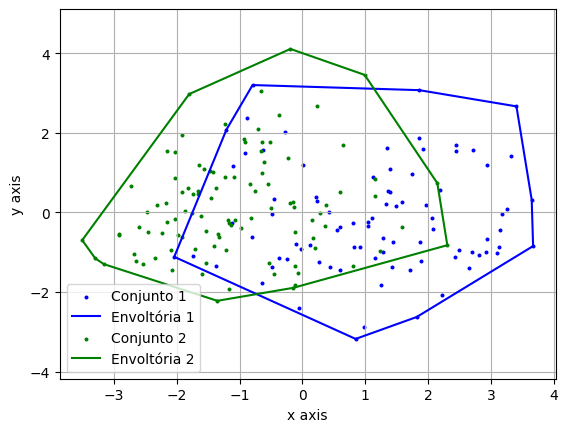

In [142]:
dataset_url = "https://media.githubusercontent.com/media/mateuskrause/keel-sklearn-csv/master/keel_standard_classification/onehot/heart.prepared.csv"
default_classification = 1

dataset = load_dataset(dataset_url, default_classification)

run_classifier(dataset)

## Conclusões

[ inserir aqui o que a gente achou dessa brincadeira ]